In [63]:
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import MinMaxScaler,LabelEncoder,StandardScaler,Normalizer,OneHotEncoder,RobustScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import ColumnTransformer
import scipy.sparse
from scipy.sparse import hstack
from sklearn.metrics import f1_score,accuracy_score,roc_auc_score, precision_score,recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
import seaborn as sns
from sklearn.metrics import roc_curve,auc, matthews_corrcoef
import itertools
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [11]:
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

In [12]:
data = pd.read_csv('encoded_data.csv')
data.shape
#data.info()

(92359, 55)

**Splitting Data into Training set and Test set**

In [13]:
X = data.drop('Score',axis=1)
y = data.Score.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, stratify= y, random_state = 42)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(61880, 54) (30479, 54) (61880,) (30479,)


# **Linear Regression**

**Fitting the model**

In [5]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [6]:
# print coefficients
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': lm.coef_}))

# print performance measures (training data)
regressionSummary(y_train, lm.predict(X_train))

                     Predictor   coefficient
0                payment_value -2.264828e-02
1                order_item_id  1.055800e+11
2                        price  1.656729e-02
3                freight_value -1.072151e-03
4          product_name_lenght -5.086564e-03
5   product_description_lenght  1.804398e-03
6           product_photos_qty  1.570290e-03
7             product_weight_g  1.164515e-03
8                delivery_days -6.160138e-02
9               estimated_days -9.449005e-03
10                    ships_in -5.302429e-04
11                arrival_time  2.814473e-01
12           seller_popularity -5.836487e-04
13           existing_customer -1.152859e-01
14                    distance  1.190948e-02
15               freight_ratio -5.722046e-03
16                        size -1.055800e+11
17         payment_type_boleto -4.097597e+10
18    payment_type_credit_card -4.097597e+10
19     payment_type_debit_card -4.097597e+10
20        payment_type_voucher -4.097597e+10
21      pa

**Performance Evaluation**

In [27]:
# Predictions on a new set
model_pred = lm.predict(X_test)

result = pd.DataFrame({'Predicted': model_pred, 'Actual': y_test, 'Residual': y_test - model_pred})
print(result.head(20))

# Performance measures (validation data)
regressionSummary(y_test, model_pred)

    Predicted  Actual  Residual
0    0.760544     1.0  0.239456
1    0.903885     1.0  0.096115
2    0.811081     0.0 -0.811081
3    0.814041     1.0  0.185959
4    0.969742     1.0  0.030258
5    0.645599     1.0  0.354401
6    0.881073     1.0  0.118927
7    0.866196     1.0  0.133804
8    0.961456     1.0  0.038544
9    0.926407     1.0  0.073593
10   0.650681     1.0  0.349319
11   0.893417     1.0  0.106583
12   0.959061     1.0  0.040939
13   0.814087     0.0 -0.814087
14   0.358566     0.0 -0.358566
15   0.936371     1.0  0.063629
16   0.854309     1.0  0.145691
17   0.756927     1.0  0.243073
18   0.903488     1.0  0.096512
19   0.919113     1.0  0.080887

Regression statistics

               Mean Error (ME) : 0.0011
Root Mean Squared Error (RMSE) : 0.3302
     Mean Absolute Error (MAE) : 0.2193


F1 Score

In [28]:
print('F1 Score = ',round(f1_score(y_test, np.round(model_pred,0), average='micro'),5))

F1 Score =  0.86578


In [29]:
print('AIC', AIC_score(y_test, lm.predict(X_test), df = len(X_train.columns) + 1))

AIC 19058.78974275764


In [30]:
model_pred = lm.predict(X_test)
all_residuals = y_test - model_pred

Percentage of datapoints with a residual in [-0.75, 0.75] = 90.6263


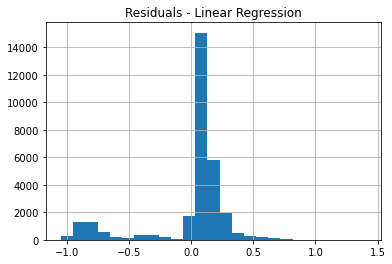

In [32]:
# Percentage of datapoints with a residual in [-0.75, 0.75] 
k = round(len(all_residuals[(all_residuals > -0.75) & (all_residuals < 0.75)]) /len(all_residuals)*100,4)
print(f'Percentage of datapoints with a residual in [-0.75, 0.75] = {k}')
%matplotlib inline
pd.DataFrame(all_residuals).hist(bins=25)
plt.title('Residuals - Linear Regression')
plt.show()

**Backwards Elimination to remove unwanted predictors**

In [33]:
def train_model(variables):
    lm = LinearRegression()
    lm.fit(X_train[variables], y_train)
    return lm

def score_model(lm, variables):
    return AIC_score(y_train, lm.predict(X_train[variables]), lm)

allVariables = X_train.columns
best_model, best_variables = backward_elimination(allVariables, train_model, 
                                 score_model, verbose=True)

print(best_variables)

regressionSummary(y_test, best_model.predict(X_test[best_variables]))

Variables: payment_value, order_item_id, price, freight_value, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, delivery_days, estimated_days, ships_in, arrival_time, seller_popularity, existing_customer, distance, freight_ratio, size, payment_type_boleto, payment_type_credit_card, payment_type_debit_card, payment_type_voucher, payment_installments_1, payment_installments_2, customer_state_BA, customer_state_DF, customer_state_ES, customer_state_GO, customer_state_MG, customer_state_PR, customer_state_RJ, customer_state_RS, customer_state_SC, customer_state_SP, seller_state_BA, seller_state_DF, seller_state_GO, seller_state_MG, seller_state_PE, seller_state_PR, seller_state_RJ, seller_state_RS, seller_state_SC, seller_state_SP, delivery_impression_0, delivery_impression_1, delivery_impression_2, estimated_del_impression_0, estimated_del_impression_1, estimated_del_impression_2, ship_impression_0, ship_impression_1, ship_impression_2, review_time_0,

**Running LinearRegression on the dataset with reduced dimension -**

In [34]:
X = data[['payment_value', 'price', 'product_name_lenght', 'product_description_lenght', 'delivery_days', 
          'estimated_days', 'arrival_time', 'existing_customer', 'distance', 'freight_ratio', 'size', 
          'payment_type_boleto', 'payment_type_voucher', 'payment_installments_2', 'customer_state_DF', 
          'customer_state_MG', 'customer_state_PR', 'customer_state_RJ', 'customer_state_SP', 'seller_state_DF', 
          'seller_state_PE', 'seller_state_RJ', 'seller_state_SP', 'delivery_impression_0', 'delivery_impression_2']]

y = data.Score.values

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify= y, random_state = 42)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(64651, 25) (27708, 25) (64651,) (27708,)


In [36]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [37]:
# print coefficients
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': lm.coef_}))

# print performance measures (training data)
regressionSummary(y_train, lm.predict(X_train))

                     Predictor  coefficient
0                payment_value    -0.023242
1                        price     0.016961
2          product_name_lenght    -0.005140
3   product_description_lenght     0.002066
4                delivery_days    -0.060052
5               estimated_days    -0.007377
6                 arrival_time     0.287591
7            existing_customer    -0.113828
8                     distance     0.011202
9                freight_ratio    -0.006512
10                        size     0.003376
11         payment_type_boleto     0.008123
12        payment_type_voucher     0.041539
13      payment_installments_2     0.024849
14           customer_state_DF    -0.028312
15           customer_state_MG    -0.017412
16           customer_state_PR    -0.014688
17           customer_state_RJ    -0.029980
18           customer_state_SP    -0.024912
19             seller_state_DF    -0.035760
20             seller_state_PE    -0.049012
21             seller_state_RJ  

**Performance Evaluation**

In [38]:
# Predictions on a new set
model_pred = lm.predict(X_test)

result = pd.DataFrame({'Predicted': model_pred, 'Actual': y_test, 'Residual': y_test - model_pred})
print(result.head(20))

# Performance measures (validation data)
regressionSummary(y_test, model_pred)

    Predicted  Actual  Residual
0    0.318005     0.0 -0.318005
1    0.941129     1.0  0.058871
2    0.781006     1.0  0.218994
3    0.851261     1.0  0.148739
4    0.579696     1.0  0.420304
5    0.880673     1.0  0.119327
6    0.566640     1.0  0.433360
7    0.880154     1.0  0.119846
8    0.926864     1.0  0.073136
9    0.943972     1.0  0.056028
10   0.861795     1.0  0.138205
11   0.765460     1.0  0.234540
12   0.922963     1.0  0.077037
13   0.907235     1.0  0.092765
14   0.908969     1.0  0.091031
15   0.902875     1.0  0.097125
16   0.881937     0.0 -0.881937
17   0.955095     1.0  0.044905
18   0.914276     1.0  0.085724
19   0.926472     1.0  0.073528

Regression statistics

               Mean Error (ME) : 0.0011
Root Mean Squared Error (RMSE) : 0.3305
     Mean Absolute Error (MAE) : 0.2194


F1 Score

In [39]:
print('F1 Score = ',round(f1_score(y_test, np.round(model_pred,0), average='micro'),5))

F1 Score =  0.86498


Percentage of datapoints with a residual in [-0.75, 0.75] = 90.5118


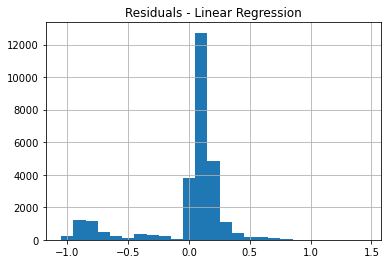

In [49]:
model_pred = lm.predict(X_test)
all_residuals = y_test - model_pred

# Percentage of datapoints with a residual in [-0.75, 0.75] 
k = round(len(all_residuals[(all_residuals > -0.75) & (all_residuals < 0.75)]) /len(all_residuals)*100,4)
print(f'Percentage of datapoints with a residual in [-0.75, 0.75] = {k}')
%matplotlib inline
pd.DataFrame(all_residuals).hist(bins=25)
plt.title('Residuals - Linear Regression')
plt.show()

**Linear Regression - Predictor Elimination**

* The dimension of the predictor set was reduced by 53.7%
* The results were same in both the cases
* The model predicts the customer staisfaction with RMS Error of 0.3305
* Residual values within the 75th quartile are very close for both the cases (difference of 0.03%)

**Forward Elimination**

In [41]:
def train_model(variables):
    if len(variables) == 0:
        return None
    lm = LinearRegression()
    lm.fit(X_train[variables], y_train)
    return lm

def score_model(lm, variables):
    if len(variables) == 0:
        return AIC_score(y_train, [y_train.mean()] * len(y_train), lm, df=1)
    return AIC_score(y_train, lm.predict(X_train[variables]), lm)

best_model, best_variables = forward_selection(X_train.columns, train_model, score_model, 
                                 verbose=True)
print(best_variables)

Variables: payment_value, price, product_name_lenght, product_description_lenght, delivery_days, estimated_days, arrival_time, existing_customer, distance, freight_ratio, size, payment_type_boleto, payment_type_voucher, payment_installments_2, customer_state_DF, customer_state_MG, customer_state_PR, customer_state_RJ, customer_state_SP, seller_state_DF, seller_state_PE, seller_state_RJ, seller_state_SP, delivery_impression_0, delivery_impression_2
Start: score=52741.31, constant
Step: score=45309.37, add arrival_time
Step: score=43288.99, add existing_customer
Step: score=41769.09, add delivery_days
Step: score=41481.19, add delivery_impression_0
Step: score=41244.80, add payment_value
Step: score=40900.15, add price
Step: score=40844.78, add distance
Step: score=40796.02, add payment_type_voucher
Step: score=40761.87, add payment_installments_2
Step: score=40741.65, add seller_state_SP
Step: score=40721.14, add delivery_impression_2
Step: score=40704.09, add customer_state_RJ
Step: sc

In [66]:
X = data[['arrival_time', 'existing_customer', 'delivery_days', 'delivery_impression_0', 'payment_value', 
          'price', 'distance', 'payment_type_voucher', 'payment_installments_1', 'seller_state_SP', 
          'delivery_impression_1', 'customer_state_RJ', 'order_item_id', 'customer_state_SP', 'estimated_days', 
          'freight_ratio', 'customer_state_MG', 'customer_state_DF', 'product_name_lenght', 'payment_type_boleto', 
          'seller_state_RJ', 'customer_state_PR', 'seller_state_DF', 'seller_state_PE', 'product_description_lenght']]

y = data.Score.values

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify= y, random_state = 42)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(64651, 25) (27708, 25) (64651,) (27708,)


In [68]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [69]:
# print coefficients
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': lm.coef_}))

# print performance measures (training data)
regressionSummary(y_train, lm.predict(X_train))

                     Predictor  coefficient
0                 arrival_time     0.287591
1            existing_customer    -0.113828
2                delivery_days    -0.060052
3        delivery_impression_0    -0.114143
4                payment_value    -0.023242
5                        price     0.016961
6                     distance     0.011202
7         payment_type_voucher     0.041539
8       payment_installments_1    -0.024849
9              seller_state_SP    -0.021465
10       delivery_impression_1     0.022947
11           customer_state_RJ    -0.029980
12               order_item_id     0.003376
13           customer_state_SP    -0.024912
14              estimated_days    -0.007377
15               freight_ratio    -0.006512
16           customer_state_MG    -0.017412
17           customer_state_DF    -0.028312
18         product_name_lenght    -0.005140
19         payment_type_boleto     0.008123
20             seller_state_RJ    -0.017843
21           customer_state_PR  

**Performance Evaluation**

In [70]:
# Predictions on a new set
model_pred = lm.predict(X_test)

result = pd.DataFrame({'Predicted': model_pred, 'Actual': y_test, 'Residual': y_test - model_pred})
print(result.head(20))

# Performance measures (validation data)
regressionSummary(y_test, model_pred)

    Predicted  Actual  Residual
0    0.318005     0.0 -0.318005
1    0.941129     1.0  0.058871
2    0.781006     1.0  0.218994
3    0.851261     1.0  0.148739
4    0.579696     1.0  0.420304
5    0.880673     1.0  0.119327
6    0.566640     1.0  0.433360
7    0.880154     1.0  0.119846
8    0.926864     1.0  0.073136
9    0.943972     1.0  0.056028
10   0.861795     1.0  0.138205
11   0.765460     1.0  0.234540
12   0.922963     1.0  0.077037
13   0.907235     1.0  0.092765
14   0.908969     1.0  0.091031
15   0.902875     1.0  0.097125
16   0.881937     0.0 -0.881937
17   0.955095     1.0  0.044905
18   0.914276     1.0  0.085724
19   0.926472     1.0  0.073528

Regression statistics

               Mean Error (ME) : 0.0011
Root Mean Squared Error (RMSE) : 0.3305
     Mean Absolute Error (MAE) : 0.2194


In [71]:
print('F1 Score = ',round(f1_score(y_test, np.round(model_pred,0), average='micro'),5))

F1 Score =  0.86498


In [73]:
matthews_corrcoef(y_test, np.round(model_pred,0))

0.3560867550484809

Percentage of datapoints with a residual in [-0.75, 0.75] = 90.5118


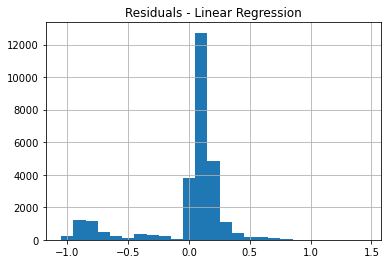

In [48]:
model_pred = lm.predict(X_test)
all_residuals = y_test - model_pred

# Percentage of datapoints with a residual in [-0.75, 0.75] 
k = round(len(all_residuals[(all_residuals > -0.75) & (all_residuals < 0.75)]) /len(all_residuals)*100,4)
print(f'Percentage of datapoints with a residual in [-0.75, 0.75] = {k}')
%matplotlib inline
pd.DataFrame(all_residuals).hist(bins=25)
plt.title('Residuals - Linear Regression')
plt.show()

* The dimension of the predictor set was reduced by 53.7%
* The results were exactly same in both the cases
* The model predicts the customer staisfaction with RMS Error of 0.3305
* Residual values within the 75th quartile are very close for both the cases (difference of 0.03%)

By comparing Forward and backward Elimination, we can see that there is no

# **Lasso Regression**

In [14]:
reg = Lasso(alpha=1)
reg.fit(X_train, y_train)

Lasso(alpha=1)

In [20]:
print('R squared training set', reg.score(X_train, y_train)*100)
print('R squared validation set', reg.score(X_test, y_test)*100)

R squared training set 0.0
R squared validation set -9.713785331655345e-09


In [23]:
from sklearn.metrics import mean_squared_error

# Training data
pred_train = reg.predict(X_train)
mse_train = mean_squared_error(y_train, pred_train)
print('MSE training set', round(mse_train, 5))

# Validation data
pred = reg.predict(X_test)
mse_test =mean_squared_error(y_test, pred)
print('MSE test set', round(mse_test, 5))

MSE training set 0.13237
MSE test set 0.13237


Text(0.5, 1.0, 'Lasso coefficients as a function of lambda')

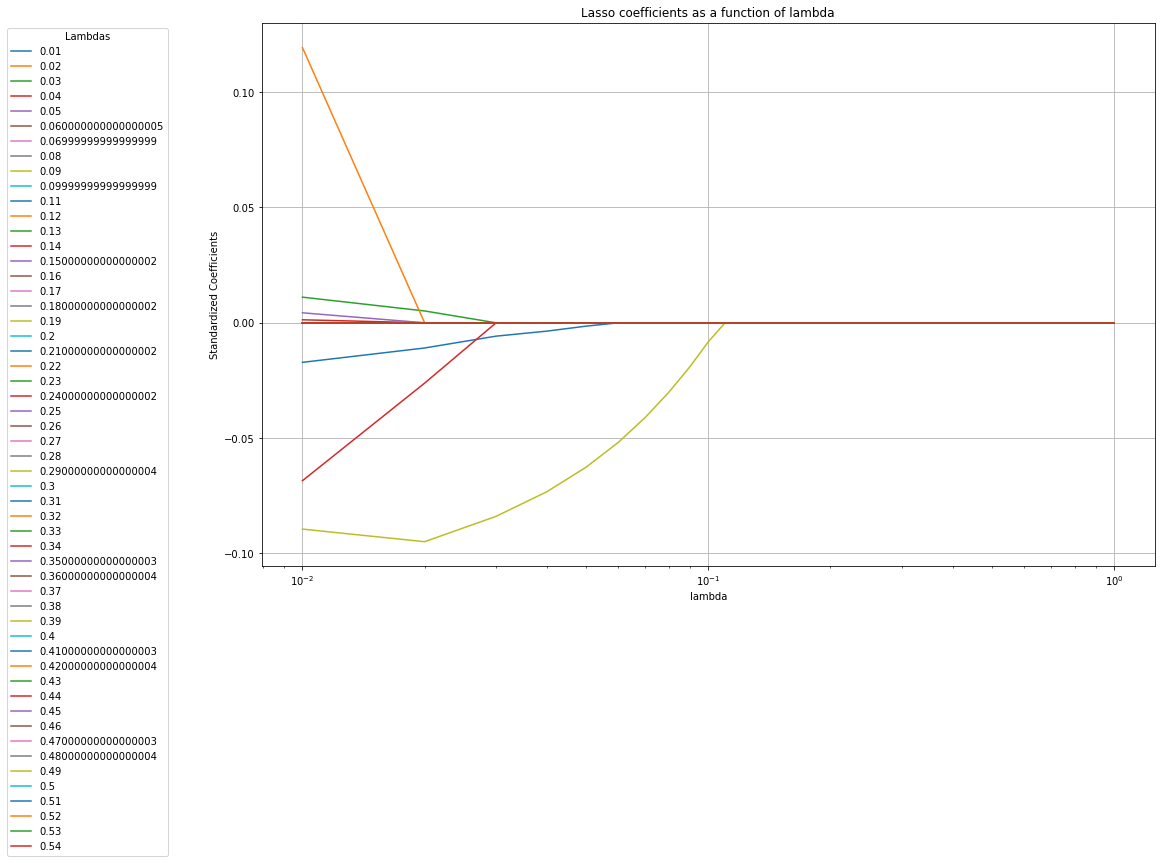

In [26]:
lambdas = np.linspace(0.01,1,100)
lasso = Lasso(max_iter=1000000)
coefs = []

for a in lambdas:
    lasso.set_params(alpha = a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
 
%matplotlib inline
plt.figure(figsize=(16,10))
ax = plt.gca()
ax.plot(lambdas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.grid()
plt.xlabel('lambda')
plt.ylabel('Standardized Coefficients')
plt.legend(lambdas,loc= 'upper right', bbox_to_anchor = (-0.1,1), title = 'Lambdas')
plt.title('Lasso coefficients as a function of lambda')

In [52]:
from sklearn.linear_model import LassoCV

# Lasso with 10 fold cross-validation
model = LassoCV(cv=10, random_state=0, max_iter=1000000)

# Fit model
model.fit(X_train, y_train)

LassoCV(cv=10, max_iter=1000000, random_state=0)

In [53]:
# Best lambda
model.alpha_

0.00010762648502654433

In [55]:
# Set best lambda
LasMod = Lasso(alpha=model.alpha_)
LasMod.fit(X_train, y_train)

Lasso(alpha=0.00010762648502654433)

In [56]:
print('R squared training set', round(LasMod.score(X_train, y_train)*100, 2))
print('R squared test set', round(LasMod.score(X_test, y_test)*100, 2))

R squared training set 17.13
R squared test set 17.48


(7.619371636262454e-05,
 0.15202645089577255,
 0.10269434772090201,
 0.1386647158213543)

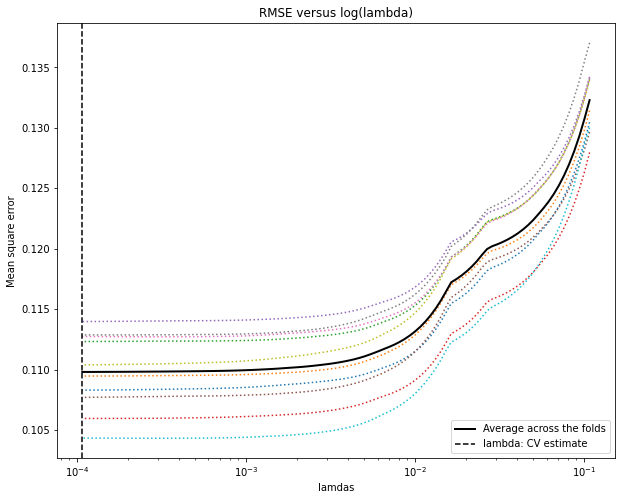

In [57]:
plt.figure(figsize=(10,8))
plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", 
    color="k", label="lambda: CV estimate"
)

plt.legend()
plt.xlabel("lamdas")
plt.ylabel("Mean square error")
plt.title("RMSE versus log(lambda)")
plt.axis("tight")

In [58]:
# Predictions on a new set
LasMod_pred = LasMod.predict(X_test)

result = pd.DataFrame({'Predicted': LasMod_pred, 'Actual': y_test, 'Residual': y_test - LasMod_pred})
print(result.head(20))

# Performance measures (validation data)
regressionSummary(y_test, LasMod_pred)

    Predicted  Actual  Residual
0    0.321714     0.0 -0.321714
1    0.942707     1.0  0.057293
2    0.782822     1.0  0.217178
3    0.852574     1.0  0.147426
4    0.578688     1.0  0.421312
5    0.880479     1.0  0.119521
6    0.565672     1.0  0.434328
7    0.877348     1.0  0.122652
8    0.927572     1.0  0.072428
9    0.943231     1.0  0.056769
10   0.858188     1.0  0.141812
11   0.763426     1.0  0.236574
12   0.922245     1.0  0.077755
13   0.911763     1.0  0.088237
14   0.905522     1.0  0.094478
15   0.906005     1.0  0.093995
16   0.881357     0.0 -0.881357
17   0.954199     1.0  0.045801
18   0.914555     1.0  0.085445
19   0.926016     1.0  0.073984

Regression statistics

               Mean Error (ME) : 0.0011
Root Mean Squared Error (RMSE) : 0.3305
     Mean Absolute Error (MAE) : 0.2196


In [59]:
LasMod_pred = LasMod.predict(X_test)
all_residuals_Las = y_test - LasMod_pred

Percentage of datapoints with a residual in [-0.75, 0.75] = 90.519


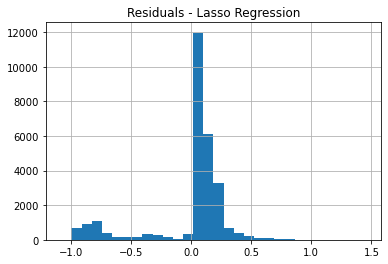

In [60]:
# Percentage of datapoints with a residual in [-0.75, 0.75] 
k = round(len(all_residuals_Las[(all_residuals_Las > -0.75) & (all_residuals_Las < 0.75)]) /len(all_residuals_Las)*100,4)
print(f'Percentage of datapoints with a residual in [-0.75, 0.75] = {k}')

pd.DataFrame(all_residuals_Las).hist(bins=30)
plt.title('Residuals - Lasso Regression')
plt.show()

In [61]:
print('F1 Score = ',round(f1_score(y_test, np.round(LasMod_pred,0), average='micro'),5))

F1 Score =  0.86509


In [62]:
print('AIC', AIC_score(y_test, LasMod_pred, df = len(X_train.columns) + 1))

AIC 17333.486882792502


In [65]:
matthews_corrcoef(y_test, np.round(LasMod_pred,0))

0.356449268421339

# **Regularization of the Regression Model**

In [49]:
lasso_cv = LassoCV(normalize=True, cv=5)
lasso_cv.fit(X_train, y_train)
regressionSummary(y_test, lasso_cv.predict(X_test))
print('Lasso-CV chosen regularization: ', lasso_cv.alpha_)
pd.DataFrame(lasso_cv.coef_, columns = ['Coefficients'])


Regression statistics

               Mean Error (ME) : 0.0011
Root Mean Squared Error (RMSE) : 0.3305
     Mean Absolute Error (MAE) : 0.2195
Lasso-CV chosen regularization:  4.71589554033958e-07


,Coefficients
0,0.287324
1,-0.113774
2,-0.059614
3,-0.114962
4,-0.023013
5,0.016766
6,0.011216
7,0.041066
8,-0.024503
9,-0.020881


In [50]:
ridge = Ridge(normalize=True, alpha=1)
ridge.fit(X_train, y_train)
regressionSummary(y_test, ridge.predict(X_test))


Regression statistics

               Mean Error (ME) : 0.0005
Root Mean Squared Error (RMSE) : 0.3356
     Mean Absolute Error (MAE) : 0.2356


In [51]:
bayesianRidge = BayesianRidge(normalize=True)
bayesianRidge.fit(X_train, y_train)
regressionSummary(y_test, bayesianRidge.predict(X_test))
alpha = bayesianRidge.lambda_ / bayesianRidge.alpha_
print('Bayesian ridge chosen regularization: ', alpha)

pd.DataFrame(bayesianRidge.coef_, columns = ['Coefficients'])


Regression statistics

               Mean Error (ME) : 0.0011
Root Mean Squared Error (RMSE) : 0.3305
     Mean Absolute Error (MAE) : 0.2195
Bayesian ridge chosen regularization:  0.0026366438471804943


,Coefficients
0,0.286828
1,-0.113681
2,-0.059591
3,-0.115656
4,-0.023048
5,0.016761
6,0.011188
7,0.041471
8,-0.024819
9,-0.021382
